# **User Configuration**

In [ ]:
# ===== USER CONFIG =====

# Drive folder where data and artifacts persist
DRIVE_BASE = "/content/drive/MyDrive/brain-tumor-cls"

# If your data is zipped in Drive (optional)
ZIP_NAME   = "figshare_interim.zip"      # set to None if you don't have a zip
MANIFEST   = "figshare_manifest.csv"     # expected CSV in data/processed

# Manifest schema (edit if your CSV uses different column names)
MANIFEST_IMAGE_COL = "path"
MANIFEST_LABEL_COL = "label"

# GitHub repo that contains your training code
REPO_URL   = "https://github.com/ArpithaPrakash/brain-tumor-cls"
REPO_NAME  = "brain-tumor-cls"               # folder name after clone

# Training configuration (all passed as CLI flags to your script)
CFG = {
    "csv":            None,              # None = auto-resolve to DRIVE_BASE/data/processed/MANIFEST
    "batch":          32,
    "epochs":         25,
    "lr":             3e-4,
    "num_classes":    3,
    "device":         "cuda",            # "cuda" or "cpu"
    "seed":           42,
    "wandb":          True,              # set False to disable W&B logging
    "wandb_project":  "idl-project",
    "wandb_run_name": "resnet50_exp1",
    # fast sanity options
    "dry_run":        False,             # True = 1 epoch, very few batches
    "limit_batches":  0,                 # 0 = no cap; e.g., 3 to cap per-epoch batches
}

# Optional Weights & Biases API key for headless login
WANDB_API_KEY = "80808f8793d0ac9fdaa65bcb08224aba64b63c24"  # e.g., "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
WANDB_ENTITY  = "arpithap-carnegie-mellon-university"


# **Logging Helpers and Shell Runner**


In [ ]:
import time, subprocess
from pathlib import Path

def log(msg):
    ts = time.strftime("%H:%M:%S")
    print(f"[{ts}] {msg}")

def run(cmd, check=True, **popen_kwargs):
    log(f"$ {cmd}")
    return subprocess.run(cmd, shell=True, check=check, text=True, **popen_kwargs)


# **Basic Filesystem Utilities**



In [ ]:
import os, shutil

def ensure_dir(path: str) -> str:
    p = Path(path)
    p.mkdir(parents=True, exist_ok=True)
    return str(p)


# **Mount Drive and Set Project Paths**

In [ ]:
def mount_drive():
    from google.colab import drive
    drive.mount('/content/drive')

def setup_paths():
    base = Path(DRIVE_BASE)
    data = base / "data"
    processed = data / "processed"
    reports = base / "reports"
    outputs = base / "outputs"
    for p in (base, data, processed, reports, outputs):
        ensure_dir(p)
    return {
        "BASE": str(base),
        "DATA": str(data),
        "PROCESSED": str(processed),
        "REPORTS": str(reports),
        "OUTPUTS": str(outputs),
    }


# **Data staging: unzip and manifest resolution**

In [ ]:
def unzip_to_base(paths):
    """Unzip ZIP_NAME into the project base so manifest paths like data/interim/... resolve."""
    if not ZIP_NAME:
        log("ZIP_NAME not set; skipping unzip.")
        return
    zip_path = Path(paths["BASE"]) / ZIP_NAME
    if not zip_path.exists():
        log(f"Zip not found at: {zip_path}. Skipping unzip.")
        return
    log(f'Unzipping {zip_path} -> {paths["BASE"]}')
    run(f'unzip -o "{zip_path}" -d "{paths["BASE"]}"')


def find_manifest(paths):
    """
    Return absolute path to the manifest CSV:
    1) PROCESSED/MANIFEST,
    2) any *manifest*.csv under PROCESSED,
    3) any .csv under PROCESSED.
    """
    target = Path(paths["PROCESSED"]) / MANIFEST
    if target.exists():
        return str(target)
    log("Manifest not found at expected path; scanning processed/ ...")
    for root, _, files in os.walk(paths["PROCESSED"]):
        for f in files:
            if f.lower().endswith(".csv") and "manifest" in f.lower():
                return str(Path(root) / f)
    for root, _, files in os.walk(paths["PROCESSED"]):
        for f in files:
            if f.lower().endswith(".csv"):
                return str(Path(root) / f)
    return None


# **Clone or refresh the GitHub repo**

In [ ]:
def clone_repo():
    repo_dir = Path("/content") / REPO_NAME
    if repo_dir.exists():
        log(f"Repository exists at {repo_dir}. Pulling latest changes.")
        os.chdir(str(repo_dir))
        try:
            run("git reset --hard")
            run("git pull --rebase")
        except subprocess.CalledProcessError:
            log("Pull failed. Re-cloning repository.")
            os.chdir("/content")
            shutil.rmtree(repo_dir, ignore_errors=True)
            run(f"git clone {REPO_URL}")
            os.chdir(str(repo_dir))
    else:
        os.chdir("/content")
        run(f"git clone {REPO_URL}")
        os.chdir(str(repo_dir))
    return str(repo_dir)


# **Install dependencies**

In [ ]:
def install_deps():
    log("Installing dependencies.")
    run("pip install --quiet --upgrade pip")
    # Install torch/vision first so Colab resolves the correct CUDA wheels
    run("pip install --quiet torch torchvision")
    run("pip install --quiet -r requirements.txt")
    if CFG.get("wandb", False):
        run("pip install --quiet wandb")
    log("Dependencies installed.")


# **Persist reports to Drive (symlink)**

In [ ]:
def link_reports_to_drive(paths, repo_dir):
    """Make repo/reports point to Drive/reports to ensure persistence."""
    repo_reports = Path(repo_dir) / "reports"
    drive_reports = Path(paths["REPORTS"])
    if repo_reports.is_symlink() or (repo_reports.exists() and repo_reports.resolve() == drive_reports):
        log("reports/ already linked to Drive.")
        return
    if repo_reports.exists():
        shutil.rmtree(repo_reports, ignore_errors=True)
    os.symlink(drive_reports, repo_reports, target_is_directory=True)
    log(f"Linked {repo_reports} -> {drive_reports}")


# **W&B login helper**

In [ ]:
def maybe_login_wandb():
    if not CFG.get("wandb", False):
        log("W&B disabled in CFG; skipping login.")
        return
    if WANDB_API_KEY:
        os.environ["WANDB_API_KEY"] = WANDB_API_KEY
        log("W&B API key set from config.")
    else:
        log("W&B is enabled. If not logged in on this runtime, a login prompt will appear on first use.")


# **Environment summary**

In [ ]:
def show_env_summary(paths, repo_dir, csv_path):
    print()
    print("=== Environment Summary ===")
    print(f"Drive base : {paths['BASE']}")
    print(f"Repo dir   : {repo_dir}")
    print(f"CSV path   : {csv_path}")
    print(f"Reports    : {paths['REPORTS']}")
    print(f"Device     : {CFG['device']}")
    print(f"W&B        : {'on' if CFG.get('wandb', False) else 'off'}")
    print("===========================")
    print()


# **Build the training command**

In [ ]:
def build_train_cmd(csv_path):
    """
    Build the CLI command to run your training script inside the repo.
    Note: your current script already saves 'best' and 'last' checkpoints to reports/.
    """
    args = {
        "--csv": csv_path,
        "--batch": str(CFG["batch"]),
        "--epochs": str(CFG["epochs"]),
        "--lr": str(CFG["lr"]),
        "--num_classes": str(CFG["num_classes"]),
        "--device": CFG["device"],
        "--seed": str(CFG["seed"]),
    }
    if CFG.get("wandb", False):
        args["--wandb"] = ""
        args["--wandb_project"] = CFG["wandb_project"]
        args["--wandb_run_name"] = CFG["wandb_run_name"]
    if CFG.get("dry_run", False):
        args["--dry_run"] = ""
    if int(CFG.get("limit_batches", 0)) > 0:
        args["--limit_batches"] = str(CFG["limit_batches"])

    cmd_parts = ["python -m src.train.train_resnet50"]
    for k, v in args.items():
        cmd_parts.append(k if v == "" else f"{k} {v}")
    return " ".join(cmd_parts)


# **Setup (mount Drive, create folders, clone repo, install deps, link reports, W&B login)**

In [ ]:
mount_drive()
paths   = setup_paths()
repo    = clone_repo()
install_deps()
link_reports_to_drive(paths, repo)
maybe_login_wandb()
log("Setup complete.")


Mounted at /content/drive
[19:39:38] $ git clone https://github.com/ArpithaPrakash/brain-tumor-cls
[19:39:40] Installing dependencies.
[19:39:40] $ pip install --quiet --upgrade pip
[19:39:46] $ pip install --quiet torch torchvision
[19:39:48] $ pip install --quiet -r requirements.txt
[19:39:50] $ pip install --quiet wandb
[19:39:52] Dependencies installed.
[19:39:52] Linked /content/brain-tumor-cls/reports -> /content/drive/MyDrive/brain-tumor-cls/reports
[19:39:52] W&B API key set from config.
[19:39:52] Setup complete.


# **Data preparation (unzip if needed, resolve manifest, environment summary)**

In [ ]:
from pathlib import Path

unzip_to_base(paths)

csv_path = CFG["csv"] or find_manifest(paths)
if not csv_path or not Path(csv_path).exists():
    raise FileNotFoundError(
        f"Could not find a CSV manifest. Looked for {MANIFEST} under {paths['PROCESSED']}.\n"
        f"Set CFG['csv'] to an absolute path if your file has a different name."
    )

show_env_summary(paths, repo, csv_path)


[19:40:21] Unzipping /content/drive/MyDrive/brain-tumor-cls/figshare_interim.zip -> /content/drive/MyDrive/brain-tumor-cls
[19:40:21] $ unzip -o "/content/drive/MyDrive/brain-tumor-cls/figshare_interim.zip" -d "/content/drive/MyDrive/brain-tumor-cls"

=== Environment Summary ===
Drive base : /content/drive/MyDrive/brain-tumor-cls
Repo dir   : /content/brain-tumor-cls
CSV path   : /content/drive/MyDrive/brain-tumor-cls/data/processed/figshare_manifest.csv
Reports    : /content/drive/MyDrive/brain-tumor-cls/reports
Device     : cuda
W&B        : on



# **Link repo/data to Drive (symlink)**

In [ ]:
# Link repo/data -> Drive/data so relative paths like "data/..." resolve
from pathlib import Path
import shutil, os

def link_data_to_drive(paths, repo_dir):
    repo_data  = Path(repo_dir) / "data"
    drive_data = Path(paths["DATA"])  # /content/drive/MyDrive/brain-tumor-cls/data

    # Remove existing repo data dir (if any) and link to Drive
    if repo_data.is_symlink() or repo_data.exists():
        try:
            if repo_data.is_symlink():
                repo_data.unlink()
            else:
                shutil.rmtree(repo_data)
        except FileNotFoundError:
            pass

    os.symlink(drive_data, repo_data, target_is_directory=True)
    print(f"Linked {repo_data} -> {drive_data}")

# run it once per runtime
link_data_to_drive(paths, repo)


Linked /content/brain-tumor-cls/data -> /content/drive/MyDrive/brain-tumor-cls/data


# **Sanity checks (schema, file existence, class distribution)**

In [ ]:
from pathlib import Path
import pandas as pd

log("Loading manifest.")
df = pd.read_csv(csv_path)

# 1) Schema check (your CSV has columns: path,label,split)
MANIFEST_IMAGE_COL = "path"
MANIFEST_LABEL_COL = "label"
required_cols = {MANIFEST_IMAGE_COL, MANIFEST_LABEL_COL}
missing_cols = required_cols - set(df.columns)
assert not missing_cols, f"Missing columns in manifest: {missing_cols}"

# 2) Robust file resolver (handles absolute or relative paths)
def resolve_path(p):
    p = Path(p)
    if p.exists():                         # absolute or already-correct relative
        return p

    base = Path(paths["BASE"])             # /content/drive/.../brain-tumor-cls
    data = Path(paths["DATA"])             # /content/drive/.../brain-tumor-cls/data
    repo_dir = Path(repo)                  # /content/brain-tumor-cls (cloned code)

    for root in (base, data, repo_dir):
        cand = root / p                    # e.g., base/"data/interim/figshare/..."
        if cand.exists():
            return cand

    # Fallback: search by filename under project base (handles extra nesting from unzip)
    try:
        for hit in base.rglob(Path(p).name):
            return hit
    except Exception:
        pass
    return None

log("Checking a sample of file paths.")
sample = df.sample(min(len(df), 500), random_state=42).copy()
sample["abs_path"] = sample[MANIFEST_IMAGE_COL].apply(resolve_path)
missing_files = sample[sample["abs_path"].isnull()]
assert missing_files.empty, f"{len(missing_files)} missing files (sampled). Example:\n{missing_files.head()}"

# 3) Label distribution
print("Class distribution:")
print(df[MANIFEST_LABEL_COL].value_counts().sort_index())


[19:55:23] Loading manifest.
[19:55:23] Checking a sample of file paths.
Class distribution:
label
glioma        3345
meningioma    2540
pituitary     2970
Name: count, dtype: int64


# **Visualize a small grid of raw samples**

[19:55:35] Rendering sample grid.


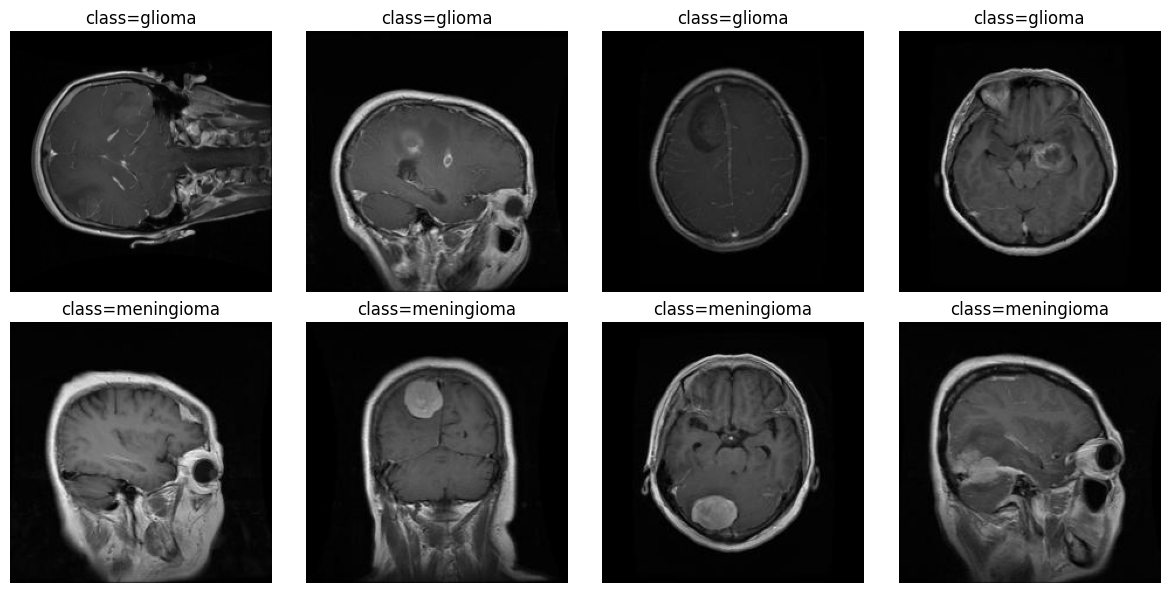

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_grid(rows=2, cols=4):
    log("Rendering sample grid.")
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = np.array(axes).reshape(rows, cols)
    grouped = df.groupby(MANIFEST_LABEL_COL)
    for r, (cls, subset) in enumerate(list(grouped)[:rows]):
        picks = subset.sample(min(cols, len(subset)), random_state=42)
        for c, (_, row) in enumerate(picks.iterrows()):
            p = resolve_path(row[MANIFEST_IMAGE_COL])
            axes[r, c].imshow(Image.open(p).convert("RGB"))
            axes[r, c].set_title(f"class={cls}")
            axes[r, c].axis("off")
    plt.tight_layout()

show_grid(rows=2, cols=4)


# **Visualize a batch after dataset transforms**

[19:55:50] Building preview dataloader.
Preview batch shapes: torch.Size([8, 3, 224, 224]) torch.Size([8])


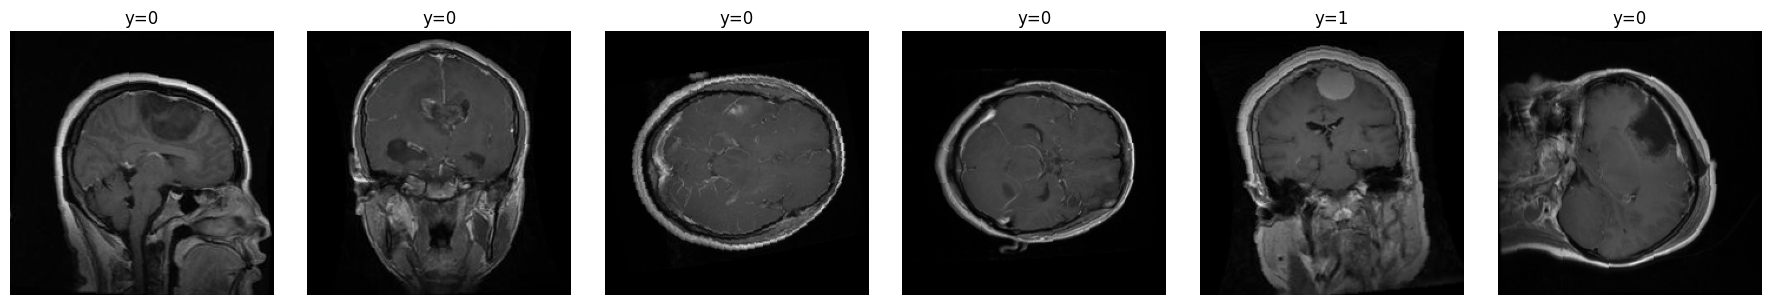

In [ ]:
# Visualize a batch after dataset transforms (deterministic preview)
import os
os.chdir(repo)  # ensure relative "data/..." paths resolve from the repo

import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from src.data.dataloaders import ManifestDataset
import matplotlib.pyplot as plt

# --- Set seeds BEFORE creating dataset/loader ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# (Optional) make CUDA convs deterministic; can slow things a bit
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

log("Building preview dataloader.")
try:
    ds_preview = ManifestDataset(csv_path, split="train")
except TypeError:
    ds_preview = ManifestDataset(csv_path, "train")

# Use a seeded generator so DataLoader shuffling is deterministic
g = torch.Generator()
g.manual_seed(SEED)

loader_preview = DataLoader(
    ds_preview,
    batch_size=8,
    shuffle=True,
    num_workers=0,          # bump to 2–4 after it works
    generator=g,           # <-- deterministic shuffle
    pin_memory=(CFG["device"] == "cuda")
)

images, labels = next(iter(loader_preview))
print("Preview batch shapes:", images.shape, labels.shape)

def to_img(t):
    x = t.detach().cpu()
    if x.ndim == 3 and x.shape[0] in (1, 3):
        if x.shape[0] == 3:  # unnormalize if ImageNet stats were used
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            x = x * std + mean
        x = x.clamp(0, 1).permute(1, 2, 0).numpy()
        return x
    return x.numpy()

cols = min(6, images.shape[0])
fig, axes = plt.subplots(1, cols, figsize=(cols*3, 3))
for i in range(cols):
    axes[i].imshow(to_img(images[i]))
    axes[i].set_title(f"y={labels[i].item()}")
    axes[i].axis("off")
plt.tight_layout()


# **Training**

In [ ]:
import os
os.environ["WANDB_PROJECT"] = "idl-project"
os.environ["WANDB_ENTITY"]  = "arpithap-carnegie-mellon-university"


In [ ]:
# Train with live tqdm bar AND save a log to Drive using a pseudo-TTY
import os, time, shutil
os.chdir(repo)
os.environ["PYTHONUNBUFFERED"] = "1"

train_cmd = build_train_cmd(csv_path).replace("python -m", "python -u -m")
log_path  = f"{paths['REPORTS']}/train_{int(time.time())}.log"

print("=== Training command ===")
print(train_cmd)
print("========================")

# If 'script' is available, use it to preserve TTY; else fallback to no-tee run
if shutil.which("script"):
    # -q: quiet  -c: run command  log_path: typescript output
    run(f'script -q -c "{train_cmd}" "{log_path}"')
    print(f"Log saved to: {log_path}")
else:
    print("`script` not available; running without a log to preserve tqdm.")
    run(train_cmd)


=== Training command ===
python -u -m src.train.train_resnet50 --csv /content/drive/MyDrive/brain-tumor-cls/data/processed/figshare_manifest.csv --batch 32 --epochs 25 --lr 0.0003 --num_classes 3 --device cuda --seed 42 --wandb --wandb_project idl-project --wandb_run_name resnet50_exp1
[19:55:57] $ script -q -c "python -u -m src.train.train_resnet50 --csv /content/drive/MyDrive/brain-tumor-cls/data/processed/figshare_manifest.csv --batch 32 --epochs 25 --lr 0.0003 --num_classes 3 --device cuda --seed 42 --wandb --wandb_project idl-project --wandb_run_name resnet50_exp1" "/content/drive/MyDrive/brain-tumor-cls/reports/train_1761335757.log"
Log saved to: /content/drive/MyDrive/brain-tumor-cls/reports/train_1761335757.log


# **Model Evaluation**

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from torchvision import transforms, models
from PIL import Image
from src.data.dataloaders import ManifestDataset
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall, MulticlassAUROC
from sklearn.metrics import matthews_corrcoef

# Define the transformations (same as training)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def make_transforms(split):
    aug = []
    if split == "test":
        aug = []  # No augmentation needed for test set
    return transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

# Load the CSV for testing
csv_path = "/content/drive/MyDrive/brain-tumor-cls/data/processed/figshare_manifest.csv"
test_dataset = ManifestDataset(csv_path, split="test")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the model (same as training)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 3)  # 3 classes
model.load_state_dict(torch.load('/content/drive/MyDrive/brain-tumor-cls/reports/best_resnet50.pt'), strict=False)
model.eval()
model.to('cuda')

# Set up metrics
acc_metric = MulticlassAccuracy(num_classes=3).to('cuda')
f1_metric = MulticlassF1Score(num_classes=3, average='macro').to('cuda')
precision_metric = MulticlassPrecision(num_classes=3, average='macro').to('cuda')
recall_metric = MulticlassRecall(num_classes=3, average='macro').to('cuda')
auc_metric = MulticlassAUROC(num_classes=3).to('cuda')

# Evaluate the model
def evaluate(model, loader):
    model.eval()
    acc_metric.reset()
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    auc_metric.reset()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)

            # Update the metrics
            acc_metric.update(outputs, labels)
            f1_metric.update(outputs, labels)
            precision_metric.update(outputs, labels)
            recall_metric.update(outputs, labels)
            auc_metric.update(outputs, labels)

    # Compute all metrics
    accuracy = acc_metric.compute()
    f1_score = f1_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    auc = auc_metric.compute()

    return accuracy, f1_score, precision, recall, auc

# Run the evaluation
accuracy, f1_score, precision, recall, auc = evaluate(model, test_loader)

# Print all the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

all_outputs = []  # List to store outputs
all_labels = []   # List to store labels

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)

        # Store the predictions and labels for the batch
        all_outputs.append(outputs.argmax(dim=1).cpu().numpy())  # Get the predicted classes
        all_labels.append(labels.cpu().numpy())  # Get the true labels

# Convert lists to numpy arrays
all_outputs = np.concatenate(all_outputs)  # Flatten list of arrays into one array
all_labels = np.concatenate(all_labels)    # Flatten list of arrays into one array

# Compute MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(all_labels, all_outputs)
print(f"Test MCC: {mcc:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Accuracy: 0.9931
Test F1 Score: 0.9932
Test Precision: 0.9933
Test Recall: 0.9931
Test AUC: 0.9999
Test MCC: 0.9898


# **Visualise Model Predictions**

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


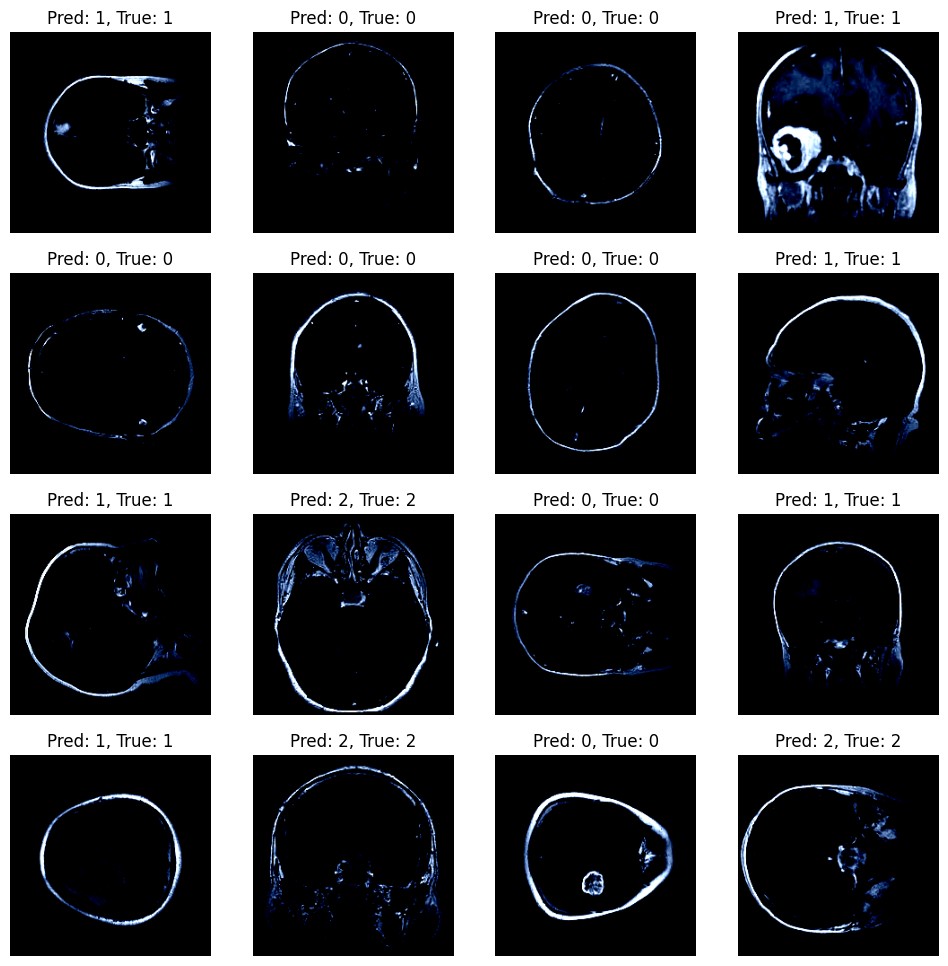

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show a batch of test images and predictions
def show_predictions(model, loader):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images, labels = images.to('cuda'), labels.to('cuda')

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Convert images back to CPU and numpy arrays
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # Plot images and predictions
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f"Pred: {preds[i]}, True: {labels[i]}")
        ax.axis('off')
    plt.show()

# Show predictions on a batch of test images
show_predictions(model, test_loader)


In [ ]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/brain-tumor-cls/reports/final_resnet50_model.pt')
